In [6]:
# Import required libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [7]:
faq_data = {
    "questions": [
        "What is the best facial cleanser for oily skin?",
        "How often should I use facial cleanser?",
        "Can I use facial cleanser on sensitive skin?",
        "What are the benefits of using a facial cleanser?",
        "Is it okay to use facial cleanser twice a day?",
        "How do I choose the right facial cleanser for my skin type?",
        "Can facial cleanser cause acne?",
        "What ingredients should I avoid in facial cleansers?",
        "Is facial cleanser better than face wash?",
        "How long does it take to see results from using a facial cleanser?",
        "Can I use facial cleanser if I have dry skin?",
        "What is the difference between a cleanser and a toner?",
        "Should I use hot or cold water with facial cleanser?",
        "Can facial cleanser remove makeup?",
        "Is it safe to use facial cleanser every day?",
    ],
    "answers": [
        "For oily skin, look for oil-control or gel-based cleansers containing ingredients like salicylic acid, tea tree oil, or benzoyl peroxide. These help remove excess sebum and prevent clogged pores.",
        "Most dermatologists recommend cleansing your face twice daily: once in the morning and once before bed. This helps remove oil, dirt, and makeup buildup.",
        "Yes, but choose a gentle, fragrance-free cleanser specifically formulated for sensitive skin. Avoid harsh ingredients like sulfates and alcohol. Patch test first to ensure no irritation.",
        "Facial cleansers help remove dirt, oil, makeup, and dead skin cells. Regular cleansing prevents acne, improves skin texture, reduces pore size, and promotes a healthy, glowing complexion.",
        "Yes, using facial cleanser twice a day (morning and night) is generally safe and recommended for most people. This maintains clean, healthy skin.",
        "Consider your skin type: oily (gel/foam cleansers), dry (cream/milk cleansers), combination (balancing cleansers), or sensitive (gentle/hypoallergenic options). Read labels and patch test first.",
        "A good cleanser should not cause acne. However, some people may experience initial breakouts due to purging. If acne persists beyond 2 weeks, switch to a different product.",
        "Avoid harsh sulfates, alcohol, and artificial fragrances. Also limit exfoliating ingredients if you have sensitive skin. Choose products with gentle, natural ingredients.",
        "There's minimal difference; the terms are often used interchangeably. Both cleanse and remove impurities. Choose based on your skin type rather than terminology.",
        "Initial improvements appear within 1-2 weeks, but significant results typically take 4-6 weeks of consistent use. Skin renewal cycles last about 28 days.",
        "Yes, dry skin types should use creamy or milk-based cleansers with moisturizing ingredients like glycerin, hyaluronic acid, or ceramides to prevent further dryness.",
        "Cleansers remove impurities, while toners balance pH, hydrate, and prepare skin for other products. Use cleansers first, then apply toner as the second step in skincare.",
        "Use lukewarm water with facial cleanser. Hot water strips natural oils and irritates skin, while cold water may not dissolve sebum effectively. Lukewarm water is ideal.",
        "Some cleansers can remove makeup, but using a dedicated makeup remover first is best. Follow with a regular facial cleanser to ensure complete removal of all residue.",
        "Yes, it's safe to use facial cleanser daily as part of your regular skincare routine. Use it morning and night for best results, but adjust frequency if skin becomes irritated."
    ]
}

faq_df = pd.DataFrame(faq_data)
print(f"✓ Loaded {len(faq_df)} FAQs about facial cleansers\n")
print("Sample FAQs:")
print(faq_df.head(3).to_string(index=False))

✓ Loaded 15 FAQs about facial cleansers

Sample FAQs:
                                      questions                                                                                                                                                                                             answers
What is the best facial cleanser for oily skin? For oily skin, look for oil-control or gel-based cleansers containing ingredients like salicylic acid, tea tree oil, or benzoyl peroxide. These help remove excess sebum and prevent clogged pores.
        How often should I use facial cleanser?                                            Most dermatologists recommend cleansing your face twice daily: once in the morning and once before bed. This helps remove oil, dirt, and makeup buildup.
   Can I use facial cleanser on sensitive skin?          Yes, but choose a gentle, fragrance-free cleanser specifically formulated for sensitive skin. Avoid harsh ingredients like sulfates and alcohol. Patch test f

In [15]:
class TextPreprocessor:

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)
    def remove_stopwords(self, tokens):
        return [token for token in tokens if token.lower() not in self.stop_words]
    
    def lemmatize(self, tokens):
        return [self.lemmatizer.lemmatize(token) for token in tokens]
    
    def preprocess(self, text):
        cleaned = self.clean_text(text)
        tokens = self.tokenize(cleaned)
        tokens = self.remove_stopwords(tokens)
        tokens = self.lemmatize(tokens)
        return tokens
    
    def preprocess_to_string(self, text):
        tokens = self.preprocess(text)
        return ' '.join(tokens)
preprocessor = TextPreprocessor()
test_question = "What are the best facial cleansers for oily skin types?"
print("Original question:")
print(f"  '{test_question}'")
print("\nPreprocessed tokens:")
tokens = preprocessor.preprocess(test_question)
print(f"  {tokens}")
print("\nPreprocessed string:")
print(f"  '{preprocessor.preprocess_to_string(test_question)}'")
print("\n✓ Text preprocessing initialized")

Original question:
  'What are the best facial cleansers for oily skin types?'

Preprocessed tokens:
  ['best', 'facial', 'cleanser', 'oily', 'skin', 'type']

Preprocessed string:
  'best facial cleanser oily skin type'

✓ Text preprocessing initialized


In [16]:
class FAQChatbot:
    def __init__(self, faq_data, preprocessor):
        self.faq_questions = faq_data["questions"]
        self.faq_answers = faq_data["answers"]
        self.preprocessor = preprocessor
        self.vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 2),
            max_features=500
        )
    
        self.faq_vectors = self.vectorizer.fit_transform(self.faq_questions)
        
    def find_best_match(self, user_question, threshold=0.3):
        user_vector = self.vectorizer.transform([user_question])
        similarities = cosine_similarity(user_vector, self.faq_vectors)[0]
        best_match_idx = np.argmax(similarities)
        best_similarity = similarities[best_match_idx]
        result = {
            'user_question': user_question,
            'matched_question': self.faq_questions[best_match_idx],
            'answer': self.faq_answers[best_match_idx],
            'similarity_score': float(best_similarity),
            'confidence': 'High' if best_similarity > 0.7 else ('Medium' if best_similarity > 0.4 else 'Low'),
            'matched_idx': best_match_idx
        }
        return result
    def find_top_k_matches(self, user_question, k=3):
        user_vector = self.vectorizer.transform([user_question])
        similarities = cosine_similarity(user_vector, self.faq_vectors)[0]
        top_k_indices = np.argsort(similarities)[-k:][::-1]
        matches = []
        for idx in top_k_indices:
            matches.append({
                'rank': len(matches) + 1,
                'matched_question': self.faq_questions[idx],
                'answer': self.faq_answers[idx],
                'similarity_score': float(similarities[idx])
            })
        
        return matches
chatbot = FAQChatbot(faq_data, preprocessor)
print("✓ FAQ Chatbot initialized successfully")
print(f"  Total FAQs in database: {len(faq_data['questions'])}")
print(f"  TF-IDF vectorizer ready with {len(chatbot.vectorizer.get_feature_names_out())} features")

✓ FAQ Chatbot initialized successfully
  Total FAQs in database: 15
  TF-IDF vectorizer ready with 74 features


In [17]:

test_questions = [
    "Which cleanser is best for oily face?",
    "How many times a day should I wash my face?",
    "Is this product safe for sensitive skin?",
    "Can I use cleanser every single day?",
    "What happens if I use hot water with face wash?",
    "Do cleansers remove makeup completely?"
]
print("=" * 80)
print("CHATBOT TESTING - SINGLE BEST MATCH")
print("=" * 80)
for i, question in enumerate(test_questions, 1):
    result = chatbot.find_best_match(question)
    print(f"\n{i}. User Question: {result['user_question']}")
    print(f"   Matched FAQ: {result['matched_question']}")
    print(f"   Similarity Score: {result['similarity_score']:.4f}")
    print(f"   Confidence: {result['confidence']}")
    print(f"   Answer: {result['answer'][:100]}...")
    print("-" * 80)

CHATBOT TESTING - SINGLE BEST MATCH

1. User Question: Which cleanser is best for oily face?
   Matched FAQ: What is the best facial cleanser for oily skin?
   Similarity Score: 0.4954
   Confidence: Medium
   Answer: For oily skin, look for oil-control or gel-based cleansers containing ingredients like salicylic aci...
--------------------------------------------------------------------------------

2. User Question: How many times a day should I wash my face?
   Matched FAQ: Is facial cleanser better than face wash?
   Similarity Score: 0.4773
   Confidence: Medium
   Answer: There's minimal difference; the terms are often used interchangeably. Both cleanse and remove impuri...
--------------------------------------------------------------------------------

3. User Question: Is this product safe for sensitive skin?
   Matched FAQ: Can I use facial cleanser on sensitive skin?
   Similarity Score: 0.6197
   Confidence: Medium
   Answer: Yes, but choose a gentle, fragrance-free cleanse

In [18]:
print("\n" + "=" * 80)
print("CHATBOT TESTING - TOP 3 MATCHES")
print("=" * 80)

sample_question = "What should I know about using facial cleanser for dry skin?"
print(f"\nUser Question: {sample_question}\n")

top_matches = chatbot.find_top_k_matches(sample_question, k=3)
for match in top_matches:
    print(f"Rank {match['rank']}:")
    print(f"  Matched FAQ: {match['matched_question']}")
    print(f"  Similarity Score: {match['similarity_score']:.4f}")
    print(f"  Answer: {match['answer'][:100]}...")
    print()


CHATBOT TESTING - TOP 3 MATCHES

User Question: What should I know about using facial cleanser for dry skin?

Rank 1:
  Matched FAQ: Can I use facial cleanser if I have dry skin?
  Similarity Score: 0.7750
  Answer: Yes, dry skin types should use creamy or milk-based cleansers with moisturizing ingredients like gly...

Rank 2:
  Matched FAQ: What are the benefits of using a facial cleanser?
  Similarity Score: 0.4121
  Answer: Facial cleansers help remove dirt, oil, makeup, and dead skin cells. Regular cleansing prevents acne...

Rank 3:
  Matched FAQ: How long does it take to see results from using a facial cleanser?
  Similarity Score: 0.2892
  Answer: Initial improvements appear within 1-2 weeks, but significant results typically take 4-6 weeks of co...



In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
class ChatbotUI:
    
    def __init__(self, chatbot):
        self.chatbot = chatbot
        self.conversation_history = []
        self.input_box = widgets.Text(
            placeholder='Ask about facial cleansers...',
            description='Question:',
            layout=widgets.Layout(width='80%')
        )
        
        self.send_button = widgets.Button(
            description='Send',
            button_style='info',
            tooltip='Click to send your question'
        )
        
        self.clear_button = widgets.Button(
            description='Clear Chat',
            button_style='warning',
            tooltip='Clear conversation history'
        )
        
        self.show_faq_button = widgets.Button(
            description='View FAQ Database',
            button_style='success',
            tooltip='Show all FAQs'
        )
        
        self.output_area = widgets.Output(layout=widgets.Layout(
            height='400px',
            border='1px solid #ccc',
            padding='10px',
            overflow_y='auto'
        ))
        
        self.send_button.on_click(self._on_send_click)
        self.clear_button.on_click(self._on_clear_click)
        self.show_faq_button.on_click(self._on_show_faq_click)
        self.input_box.on_submit(self._on_send_click)
        
    def _on_send_click(self, button):
        """Handle send button click"""
        question = self.input_box.value.strip()
        
        if not question:
            with self.output_area:
                print("⚠️  Please enter a question!")
            return
        
        result = self.chatbot.find_best_match(question)
        self.conversation_history.append({
            'type': 'user',
            'content': question
        })
        
        self.conversation_history.append({
            'type': 'bot',
            'content': result
        })
        self._update_output()
        self.input_box.value = ''
    
    def _on_clear_click(self, button):
        self.conversation_history = []
        with self.output_area:
            clear_output()
        print("Chat cleared!")
    
    def _on_show_faq_click(self, button):
        with self.output_area:
            clear_output()

        print("📚 FACIAL CLEANSER FAQ DATABASE")
        print("=" * 80)
        
        with self.output_area:
            for i, (q, a) in enumerate(zip(self.chatbot.faq_questions, self.chatbot.faq_answers), 1):
                print(f"\n{i}. Q: {q}")
                print(f"   A: {a[:150]}...")
    
    def _update_output(self):
        with self.output_area:
            clear_output()
        
        for msg in self.conversation_history:
            with self.output_area:
                if msg['type'] == 'user':
                    print(f"\n👤 You: {msg['content']}")
                else:
                    result = msg['content']
                    print(f"\n🤖 Chatbot:")
                    print(f"   Matched FAQ: {result['matched_question']}")
                    print(f"   Confidence: {result['confidence']} ({result['similarity_score']:.2%})")
                    print(f"\n   📝 Answer:")
                    print(f"   {result['answer']}")
                    print("\n" + "-" * 80)
    
    def display(self):
        title = widgets.HTML("<h2>🧴 Facial Cleanser FAQ Chatbot</h2>")
        button_row = widgets.HBox([
            self.send_button,
            self.clear_button,
            self.show_faq_button
        ])
        
        input_section = widgets.VBox([
            self.input_box,
            button_row
        ])
        main_layout = widgets.VBox([
            title,
            widgets.HTML("<p>Ask any question about facial cleansers!</p>"),
            input_section,
            self.output_area
        ], layout=widgets.Layout(padding='20px'))
        
        return display(main_layout)
print("Initializing interactive chatbot UI...")
ui = ChatbotUI(chatbot)
ui.display()

Initializing interactive chatbot UI...


CHATBOT PERFORMANCE ANALYSIS

Analyzing 6 test questions:

Average Similarity Score: 0.5481
Min Similarity Score: 0.4773
Max Similarity Score: 0.7172
Std Deviation: 0.0900

Confidence Distribution:
  High Confidence: 1 (16.7%)
  Medium Confidence: 5 (83.3%)
  Low Confidence: 0 (0.0%)


Matplotlib is building the font cache; this may take a moment.


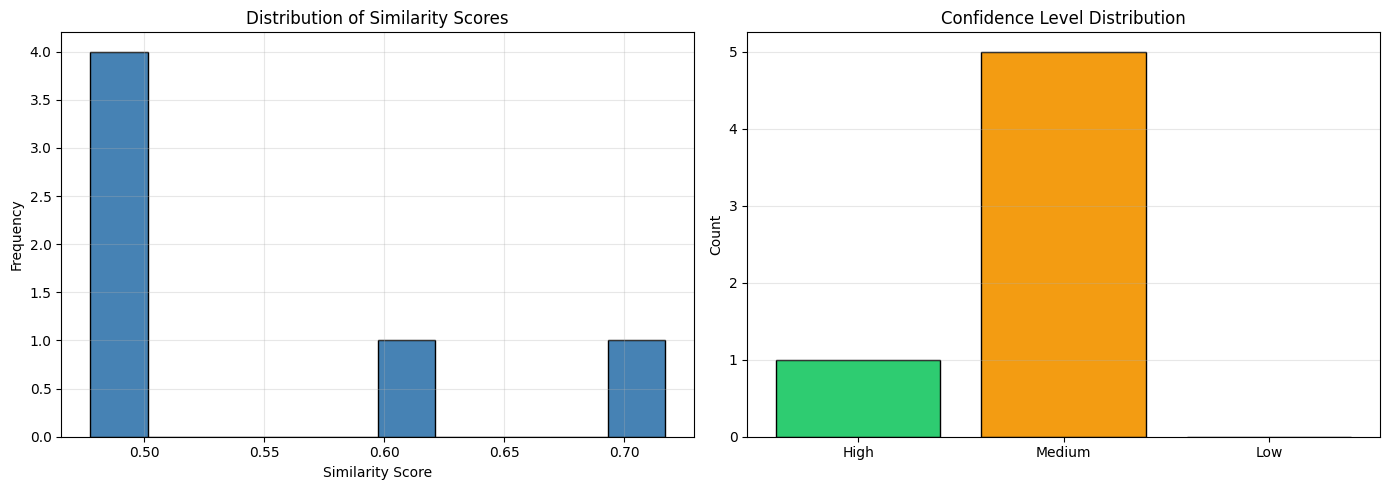


✓ Performance analysis complete


In [13]:
print("=" * 80)
print("CHATBOT PERFORMANCE ANALYSIS")
print("=" * 80)
all_results = []
for question in test_questions:
    result = chatbot.find_best_match(question)
    all_results.append(result)
similarity_scores = [r['similarity_score'] for r in all_results]
confidence_levels = [r['confidence'] for r in all_results]

print(f"\nAnalyzing {len(test_questions)} test questions:\n")
print(f"Average Similarity Score: {np.mean(similarity_scores):.4f}")
print(f"Min Similarity Score: {np.min(similarity_scores):.4f}")
print(f"Max Similarity Score: {np.max(similarity_scores):.4f}")
print(f"Std Deviation: {np.std(similarity_scores):.4f}")

print(f"\nConfidence Distribution:")
high = confidence_levels.count('High')
medium = confidence_levels.count('Medium')
low = confidence_levels.count('Low')
print(f"  High Confidence: {high} ({high/len(confidence_levels)*100:.1f}%)")
print(f"  Medium Confidence: {medium} ({medium/len(confidence_levels)*100:.1f}%)")
print(f"  Low Confidence: {low} ({low/len(confidence_levels)*100:.1f}%)")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(similarity_scores, bins=10, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Similarity Scores')
axes[0].grid(alpha=0.3)
confidence_counts = {'High': high, 'Medium': medium, 'Low': low}
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[1].bar(confidence_counts.keys(), confidence_counts.values(), color=colors, edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title('Confidence Level Distribution')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Performance analysis complete")